## Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your score will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment.
___

Create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import export_graphviz
import pydotplus

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# get csv data
blight_data = pd.read_csv('train.csv', encoding='ISO-8859-1', dtype='object').set_index('ticket_id')
address_data = pd.read_csv('addresses.csv', encoding='ISO-8859-1', dtype='object')
#test_data = pd.read_csv('test.csv', encoding='ISO-8859-1', dtype='object').set_index('ticket_id')

#### First let's take a look at the data:

In [3]:
blight_data.describe(include='all').T

,count,unique,top,freq
agency_name,250306,5,"Buildings, Safety Engineering & Env Department",157784
inspector_name,250306,173,"Morris, John",17926
violator_name,250272,119992,"INVESTMENT, ACORN",809
violation_street_number,250306,19175,1509.0,240
violation_street_name,250306,1791,SEVEN MILE,3482
violation_zip_code,0,0,NaN,NaN
mailing_address_str_number,246704,15826,213,1934
mailing_address_str_name,250302,37896,PO BOX,8668
city,250306,5184,DETROIT,136936
state,250213,59,MI,228601


Columns that have many unique values will not be very good in predicting the outcomes for the test data. 
Ticket issued date, violateor name, mailing address number and street name information might not be useful to create a good predictor. 


Let's also take a look into the address.csv file. See what useful information we can get from it:

In [4]:
address_by_ticket = address_data['address']
city, state = zip(*address_by_ticket.apply(lambda txt: txt.split(', ')[1].split(' ')))

city_state_by_ticket = pd.DataFrame([city, state], index=['violation_city', 'violation_state'], columns=address_data['ticket_id']).T
city_state_by_ticket.describe(include='all')

,violation_city,violation_state
count,311307,311307
unique,1,1
top,Detroit,MI
freq,311307,311307


In [5]:
print(address_data.head())

  ticket_id                      address
0     22056       2900 tyler, Detroit MI
1     27586     4311 central, Detroit MI
2     22062  1449 longfellow, Detroit MI
3     22084  1441 longfellow, Detroit MI
4     22093   2449 churchill, Detroit MI


The address.csv doesn't provide any useful information.

#### Now change the compliance column from train.csv to change the NaN values (not responsible) to 2. Let's call it "y" because that's the dependent variable for our models.

In [6]:
# Predict the non-compliance

#NaN = Not Responsible
# 0 = Non-compliant
# 1 = Compliant
print('---- Check whats in compliance column ----')
print(blight_data['compliance'].value_counts(dropna=False)/len(blight_data['compliance']))

# non compliant = 0
# compliant = 1
# NaN = -1

print('\n---- Covert to float and change NaNs to 1.0 ----')
y = blight_data['compliance'].apply(lambda r: 2.0 if pd.isnull(r) else float(r))
print(y.value_counts()/len(y))

---- Check whats in compliance column ----
0.0    0.592407
NaN    0.361262
1.0    0.046331
Name: compliance, dtype: float64

---- Covert to float and change NaNs to 1.0 ----
0.0    0.592407
2.0    0.361262
1.0    0.046331
Name: compliance, dtype: float64


#### Agency name could be a good predictor. Let's look at the unique values and the mean of results - transforming the compliance column to get a better image of compliance and non-compliance. 

In [19]:
#agency name

from summarize_data import avg_predict_by_col

blight_responsible = blight_data.dropna(subset=['compliance'])
avg_predict_by_col(blight_responsible['compliance'].astype(float), blight_responsible['agency_name'])

compliance                 
                                                     mean       std  count
agency_name                                                               
Buildings, Safety Engineering & Env Department   0.060743  0.238859  95863
Department of Public Works                       0.089961  0.286128  52445
Detroit Police Department                        0.131720  0.338224   4464
Health Department                                0.065851  0.248038   7107
Neighborhood City Halls                          0.000000       NaN      1

#### Are there any difference in compliance depending on the inspector?

In [23]:
# calculate average compliance by inspector name
by_inspector = avg_predict_by_col(blight_responsible['compliance'].astype(float), 
                                  blight_responsible['inspector_name'])['compliance']

by_inspector[by_inspector['count']> 1000].sort_values('mean', ascending=False)

,mean,std,count
inspector_name,,,
"Talbert, Reginald",0.124311,0.330037,1633
"Moore, David",0.112877,0.316529,1825
"Johnson, Lois",0.112027,0.315476,2062
"Williamson, Lillett",0.101365,0.301909,1539
"Havard, Jacqueline",0.101027,0.301426,2435
"OBannon, James",0.098695,0.298374,1226
"Cato, Valesta",0.098223,0.297755,1069
"Forte, Laurie",0.097578,0.296846,1445
"Davis, Darlene",0.096029,0.294684,2770


#### Using the violators' information, check if they are from a state in the US or if they are foreign. Separate by state or foreign: 

In [32]:
us_states = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL',
             'IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT',
             'NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI',
             'SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

locations = blight_data['state'].apply(lambda state: state if state in us_states else 'foreign')

avg_predict_by_col(blight_responsible['compliance'].astype(float),
                   locations)['compliance'].sort_values('count', ascending=False)

,mean,std,count
state,,,
MI,0.073753,0.261370,143655
CA,0.047544,0.212828,3828
TX,0.046107,0.209770,1952
FL,0.063095,0.243207,1680
SC,0.020638,0.142236,1066
IL,0.119420,0.324463,896
OH,0.123631,0.329418,639
NY,0.080374,0.272126,535
MN,0.040268,0.196808,447


#### Even though though there is variation between states, let's make it simpler, let's check mean compliance if the violator is foreign, out-of-state of from MI:

In [33]:
out_of_state = locations.apply(lambda loc: 'out-of-state' if loc != 'foreign' and loc != 'MI' else loc)

avg_predict_by_col(blight_responsible['compliance'].astype(float),
                   out_of_state)['compliance'].sort_values('mean')

,mean,std,count
state,,,
out-of-state,0.060976,0.239293,15908
MI,0.073753,0.261370,143655
foreign,0.100946,0.301734,317


It is interesting to see that foreigners are more likely to comply than the other groups. 

#### What about disposition?

In [41]:
dispostion_dictionary = {'Not responsible by Dismissal': 'Not Responsible',
                         'Not responsible by City Dismissal': 'Not Responsible',
                         'Not responsible by Determination': 'Not Responsible',
                         'PENDING JUDGMENT': 'Pending',
                         'SET-ASIDE (PENDING JUDGMENT)': 'Pending',
                         'Responsible (Fine Waived) by Deter': 'Fine Waived'
                        }

disposition = blight_data['disposition'].replace(dispostion_dictionary)

avg_predict_by_col(blight_responsible['compliance'].astype(float), 
                   disposition)['compliance'].sort_values('count', ascending=False)

,mean,std,count
disposition,,,
Responsible by Default,0.038203,0.191687,138340
Responsible by Admission,0.275016,0.446539,13701
Responsible by Determination,0.307300,0.461405,7644
Fine Waived,1.000000,0.000000,195
Not Responsible,NaN,NaN,0
Pending,NaN,NaN,0


Disposition seems like a good predictor. Is this data leakage?

#### If the costs are higher, are people more likely not to comply?

In [42]:
judgment_amount_cut = pd.cut(blight_data.loc[:, 'judgment_amount'].astype(float), bins=5)
                             
avg_predict_by_col(blight_responsible['compliance'].astype(float), 
                   judgment_amount_cut)

compliance                  
                        mean       std   count
judgment_amount                               
(-11.03, 2206.0]    0.074395  0.262414  154163
(2206.0, 4412.0]    0.023419  0.151243    5423
(4412.0, 6618.0]    0.000000  0.000000      85
(6618.0, 8824.0]    0.000000  0.000000      13
(8824.0, 11030.0]   0.005102  0.071429     196

Seems like it. As judgments amounts increase, mean compliance decrease.

In [44]:
X_actuals = pd.concat([disposition, judgment_amount_cut, out_of_state], axis=1)
X_actuals.head()

,disposition,judgment_amount,state
ticket_id,,,
22056,Responsible by Default,"(-11.03, 2206.0]",out-of-state
27586,Responsible by Determination,"(-11.03, 2206.0]",MI
22062,Not Responsible,"(-11.03, 2206.0]",MI
22084,Not Responsible,"(-11.03, 2206.0]",MI
22093,Not Responsible,"(-11.03, 2206.0]",MI


In [45]:
X = pd.get_dummies(X_actuals)

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

grid_tree_clf = GridSearchCV(RandomForestClassifier(), 
                             param_grid={'criterion': ['entropy'], 
                                         'n_estimators': np.arange(1,50,5)}, cv = 3, n_jobs=-1)


grid_tree_clf.fit(X_train, y_train)
 
naive_tree_prediction = grid_tree_clf.predict(X_test)
naive_tree_score = grid_tree_clf.predict_proba(X_test).T

Accuracy score: 0.955 
Precison Score(base 0.0):0.976 
Recall Score(base:0.0):0.673


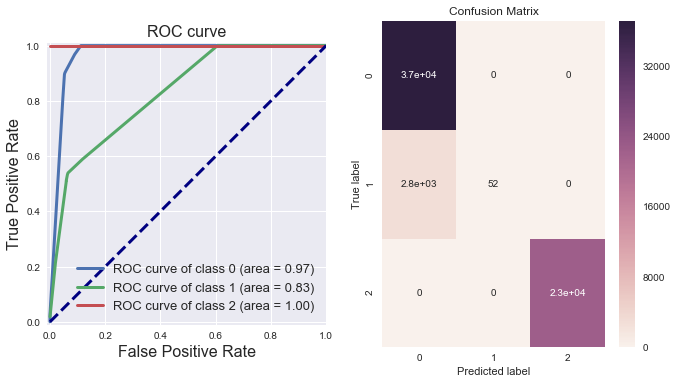

In [77]:
# create matplotlib charts
# ROC AUC Chart
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score

fig, ax = plt.subplots(1, 2, figsize=(11,6))

for i, _ in enumerate(naive_tree_score):

    naive_tree_fpr, naive_tree_tpr, _ = roc_curve(y_true = y_test, 
                                              pos_label = i, 
                                              y_score = naive_tree_score[i])
    
    naive_tree_roc_auc = auc(naive_tree_fpr, naive_tree_tpr)

    ax[0].plot(naive_tree_fpr, naive_tree_tpr, lw=3, label='ROC curve of class {:.0f} (area = {:0.2f})'.format(i, naive_tree_roc_auc))

ax[0].set_xlim([-0.01, 1.00])
ax[0].set_ylim([-0.01, 1.01])
ax[0].set_xlabel('False Positive Rate', fontsize=16)
ax[0].set_ylabel('True Positive Rate', fontsize=16)
ax[0].set_title('ROC curve', fontsize=16)
ax[0].legend(loc='lower right', fontsize=13)
ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax[0].set_aspect('equal')

#Confusion Matrix
df_cm = pd.DataFrame(confusion_matrix(y_test.values, naive_tree_prediction), 
                     index = [i for i in range(0, len(y.unique()))], 
                     columns = [i for i in range(0, len(y.unique()))])

sns.heatmap(df_cm, annot=True)
ax[1].set_title('Confusion Matrix')
ax[1].set_ylabel('True label')
ax[1].set_xlabel('Predicted label')

print('Accuracy score: {:.3f} \nPrecison Score(base 0.0):{:.3f} \nRecall Score(base:0.0):{:.3f}'
      .format(accuracy_score(y_test, naive_tree_prediction),
             precision_score(y_test, naive_tree_prediction, average='macro'),
             recall_score(y_test, naive_tree_prediction, average='macro')))
plt.show()

# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate

Random forest performed well. It was able achieved high accuracy and precision. Recall was not as good given that the model did not predict true label 1 as well. 